# Two-dimensional Burgers equation

Consider the three-dimensional (3D) coupled viscous Burger equation
$$
\begin{array}{c}
\frac{\partial u}{\partial t}+u \frac{\partial u}{\partial x}+v \frac{\partial u}{\partial y}+w \frac{\partial u}{\partial z}=\nu\left(\frac{\partial^{2} u}{\partial x^{2}}+\frac{\partial^{2} u}{\partial y^{2}}+\frac{\partial^{2} u}{\partial z^{2}}\right) \\
\frac{\partial v}{\partial t}+u \frac{\partial v}{\partial x}+v \frac{\partial v}{\partial y}+w \frac{\partial v}{\partial z}=\nu\left(\frac{\partial^{2} v}{\partial x^{2}}+\frac{\partial^{2} v}{\partial y^{2}}+\frac{\partial^{2} v}{\partial z^{2}}\right) \\
\frac{\partial w}{\partial t}+u \frac{\partial w}{\partial x}+v \frac{\partial w}{\partial y}+w \frac{\partial w}{\partial z}=\nu\left(\frac{\partial^{2} w}{\partial x^{2}}+\frac{\partial^{2} w}{\partial y^{2}}+\frac{\partial^{2} w}{\partial z^{2}}\right)
\end{array}
$$
The initial conditions are considered as
$$
\left\{\begin{array}{rl}
u(x, y, z, 0) & =\psi_{1}(x, y, z),(x, y, z) \in \Omega \\
v(x, y, z, 0) & =\psi_{2}(x, y, z),(x, y, z) \in \Omega \\
w(x, y, z, 0) & =\psi_{3}(x, y, z),(x, y, z) \in \Omega
\end{array}\right.
$$

and Dirichlet boundary conditions are taken as
$$
\left\{\begin{array}{rl}
u(x, y, z, t) & =\xi_{1}(x, y, z, t),(x, y, z) \in \partial \Omega \\

v(x, y, z, t) & =\xi_{2}(x, y, z, t),(x, y, z) \in \partial \Omega \\
w(x, y, z, t) & =\xi_{3}(x, y, z, t),(x, y, z) \in \partial \Omega
\end{array}\right., t>0,
$$
where  $\Omega=\{(x, y, z): a \leq x \leq b, c \leq y \leq d, e \leq z \leq f\} $ is the computational domain and  $\partial \Omega$  is its boundary,  $u(x, y, z, t), v(x, y, z, t)$ and $w(x, y, z, t)$ are the velocity components to be determined,  $\psi_{1}, \psi_{2}, \psi_{3}, \xi_{1}, \xi_{2}$  and  $\xi_{3}$  are known functions,  $\frac{\partial u}{\partial t}$  is the unsteady term,  $u \frac{\partial u}{\partial x}$  is the nonlinear convection term,  $\nu=\frac{1}{\operatorname{Re}}$  is the kinematic viscosity,  $\frac{1}{\operatorname{Re}}\left(\frac{\partial^{2} u}{\partial x^{2}}+\frac{\partial^{2} u}{\partial y^{2}}+\frac{\partial^{2} u}{\partial z^{2}}\right) $ is the diffusion term and Re is the Reynolds number.
Coupled viscous Burger equation is a most significant form of the Navier-Stokes equations possessing the same convective and diffusive terms as the incompressible Navier-Stokes equations. The numerical solution of the coupled Burger equation plays an important role in fluid flow problems such as shock wave theory, wave processes in thermoelastic medium, hydrodynamic turbulence, dispersion in porous media, vorticity transport, etc.


 \begin{array}{l}
u(x, y, z, t)=-\frac{2}{\mathrm{Re}}\left(\frac{1+\cos (x) \sin (y) \sin (z \exp (-t)}{1+x+\sin (x) \sin (y) \sin (z) \exp (-t)}\right) \\
v(x, y, z, t)=-\frac{2}{\operatorname{Re}}\left(\frac{\sin (x) \cos (y) \sin (z) \exp (-t)}{1+x+\sin (x) \sin (y) \sin (z) \exp (-t)}\right) \\
w(x, y, z, t)=-\frac{2}{\operatorname{Re}}\left(\frac{\sin (x) \sin (y) \cos (z) \exp (-t)}{1+x+\sin (x) \sin (y) \sin (z) \exp (-t)}\right)
\end{array}

## 1.Setup

In [1]:
import torch
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from math import *
import time
import copy


# %%
torch.set_default_tensor_type('torch.DoubleTensor')

## 2.Hyperparameter

In [4]:
dimension = 4
input_width,layer_width = dimension, 4
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

## 3.Neural Architecture

In [15]:

# activation function
def activation(x):
    return torch.mul(x, torch.sigmoid(x))

class Net(torch.nn.Module):
    def __init__(self,input_width,layer_width,layer_depth):
        super(Net,self).__init__()
        self.layer_in = torch.nn.Linear(input_width, layer_width)
        for i in range(layer_depth-1):
            setattr(self, 'layer'+str(i), torch.nn.Linear(layer_width, layer_width))
        self.layer_out = torch.nn.Linear(layer_width, 3)
    def forward(self,x,layer_depth):
        y = activation(self.layer_in(x))
        for i in range(layer_depth-1):
            y = activation(getattr(self, 'layer'+str(i))(y))
        output = self.layer_out(y)
        return output

${\rm N}(\vec{x}) := {\rm A}_{\rm 4}(\sigma{\rm A}_3({\sigma}{\rm A}_2({\sigma}{\rm A}_{\rm 1}(\vec{x}))))\ ,$, where

${\rm A}_{\rm in}: \mathbb{R}^4{→}\mathbb{R}^w$, ${\rm A}_1: \mathbb{R}^w{→}\mathbb{R}^w$, ${\rm A}_2: \mathbb{R}^w{→}\mathbb{R}^w$, ${\rm A}_{\rm out}: \mathbb{R}^w{→}\mathbb{R}^3$, 

note: there are $2w^2+10w+3$ parameters need to be trained in total in ${\rm N}(x)$

## 4.Training setup

### 4.1 Initialize the weights using Xavier normal initialization

In [16]:
# %%
# Xavier normal initialization for weights:
#             mean = 0 std = gain * sqrt(2 / fan_in + fan_out)
# zero initialization for biases
def initialize_weights(self):
    for m in self.modules():
        if isinstance(m,nn.Linear):
            nn.init.xavier_normal_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()



### 4.2 Define $u_0$, $v_0$

$$\left\{\begin{array}{l}
u_{0}(x, y, z, 0)=-\frac{2}{\mathrm{Re}}\left(\frac{1+\cos (x) \sin (y) \sin (z)}{1+x+\sin (x) \sin (y) \sin (z) }\right) \\
v_{0}(x, y, z, 0)=-\frac{2}{\operatorname{Re}}\left(\frac{\sin (x) \cos (y) \sin (z)}{1+x+\sin (x) \sin (y) \sin (z)}\right) \\
w_{0}(x, y, z, 0)=-\frac{2}{\operatorname{Re}}\left(\frac{\sin (x) \sin (y) \cos (z)}{1+x+\sin (x) \sin (y) \sin (z)}\right)
\end{array}\right.$$

In [17]:
# Define u_0
def u_0(X):
    u_temp = torch.zeros(X.shape[0],1)
    x = X[:,0]
    y = X[:,1]
    z = X[:,2]
    temp1 = torch.add(1,torch.mul(torch.cos(x),torch.mul(torch.sin(y),torch.sin(z))))
    temp2 = torch.add(1,torch.mul(torch.sin(x),torch.mul(torch.sin(y),torch.sin(z))))
    temp2 = torch.add(x,temp2)
    temp = torch.div(temp1,temp2)
    temp = torch.mul(-2,torch.mul(nu,temp))
    u_temp[:,0] = temp
    return u_temp.reshape([X.size()[0],1]).to(device)

def v_0(X):
    u_temp = torch.zeros(X.shape[0],1)
    x = X[:,0]
    y = X[:,1]
    z = X[:,2]
    temp1 = torch.mul(torch.sin(x),torch.mul(torch.cos(y),torch.sin(z)))
    temp2 = torch.add(1,torch.mul(torch.sin(x),torch.mul(torch.sin(y),torch.sin(z))))
    temp2 = torch.add(x,temp2)
    temp = torch.div(temp1,temp2)
    temp = torch.mul(-2,torch.mul(nu,temp))
    u_temp[:,0] = temp
    return u_temp.reshape([X.size()[0],1]).to(device)


def w_0(X):
    u_temp = torch.zeros(X.shape[0],1)
    x = X[:,0]
    y = X[:,1]
    z = X[:,2]
    temp1 = torch.mul(torch.sin(x),torch.mul(torch.sin(y),torch.cos(z)))
    temp2 = torch.add(1,torch.mul(torch.sin(x),torch.mul(torch.sin(y),torch.sin(z))))
    temp2 = torch.add(x,temp2)
    temp = torch.div(temp1,temp2)
    temp = torch.mul(-2,torch.mul(nu,temp))
    u_temp[:,0] = temp
    return u_temp.reshape([X.size()[0],1]).to(device)


### 4.3 Define the exact solution


 \begin{array}{l}
u(x, y, z, t)=-\frac{2}{\mathrm{Re}}\left(\frac{1+\cos (x) \sin (y) \sin (z \exp (-t)}{1+x+\sin (x) \sin (y) \sin (z) \exp (-t)}\right) \\
v(x, y, z, t)=-\frac{2}{\operatorname{Re}}\left(\frac{\sin (x) \cos (y) \sin (z) \exp (-t)}{1+x+\sin (x) \sin (y) \sin (z) \exp (-t)}\right) \\
w(x, y, z, t)=-\frac{2}{\operatorname{Re}}\left(\frac{\sin (x) \sin (y) \cos (z) \exp (-t)}{1+x+\sin (x) \sin (y) \sin (z) \exp (-t)}\right)
\end{array}


In [18]:
def u_exact(X):
    x = X[:,0]
    y = X[:,1]
    z = X[:,2]
    t = X[:,3]
    
    temp1 = -2*nu*(1+torch.cos(x)*torch.sin(y)*torch.sin(z*torch.exp(-t)))/(1+x+torch.sin(x)*torch.sin(y)*torch.sin(z)*torch.exp(-t))
    temp2 = -2*nu*(torch.sin(x)*torch.cos(y)*torch.sin(z)*torch.exp(-t))/(1+x+torch.sin(x)*torch.sin(y)*torch.sin(z)*torch.exp(-t))
    temp3 = -2*nu*(torch.sin(x)*torch.sin(y)*torch.cos(z)*torch.exp(-t))/(1+x+torch.sin(x)*torch.sin(y)*torch.sin(z)*torch.exp(-t))
    u_temp = torch.zeros(x.size()[0],3)
    u_temp[:,0] = temp1
    u_temp[:,1] = temp2
    u_temp[:,2] = temp3
    return u_temp.reshape([x.size()[0],3]).to(device)

In [19]:
def g_0x(X):
    x = torch.zeros([X.shape[0],1])[:,0].to(device)
    x.requires_grad = True
    y = X[:,1].to(device)
    z = X[:,2].to(device)
    t = X[:,3].to(device)
    temp1 = torch.mul(torch.exp(-t),torch.mul(torch.cos(x),torch.mul(torch.sin(y),torch.sin(z))))
    temp1 = torch.add(temp1,1)
    temp2 = torch.mul(torch.exp(-t),torch.mul(torch.sin(x),torch.mul(torch.sin(y),torch.sin(z))))
    temp2 = torch.add(temp2,x)
    temp2 = torch.add(temp2,1)
    temp1 = torch.div(temp1,temp2)
    temp1 = torch.mul(-2,torch.mul(nu,temp1))
    u_temp = temp1
    return u_temp.reshape([x.size()[0], 1])
    
def g_1x(X):
    x = torch.ones([X.shape[0],1])[:,0].to(device)
    x.requires_grad = True
    y = X[:,1].to(device)
    z = X[:,2].to(device)
    t = X[:,3].to(device)

    # use cuda torch to write temp1 = (x+y-2*x*t)/(1-2*t**2)
    temp1 = torch.mul(torch.exp(-t),torch.mul(torch.cos(x),torch.mul(torch.sin(y),torch.sin(z))))
    temp1 = torch.add(temp1,1)
    temp2 = torch.mul(torch.exp(-t),torch.mul(torch.sin(x),torch.mul(torch.sin(y),torch.sin(z))))
    temp2 = torch.add(temp2,x)
    temp2 = torch.add(temp2,1)
    temp1 = torch.div(temp1,temp2)
    temp1 = torch.mul(-2,torch.mul(nu,temp1))
    u_temp = temp1
    return u_temp.reshape([x.size()[0], 1])


def g_0y(X):
    x = X[:,0].to(device)
    y = torch.zeros([X.shape[0],1])[:,0].to(device)
    y.requires_grad = True
    z = X[:,2].to(device)
    t = X[:,3].to(device)
    temp1 = torch.mul(torch.exp(-t),torch.mul(torch.sin(x),torch.mul(torch.cos(y),torch.sin(z))))
    temp1 = torch.add(temp1,1)
    temp2 = torch.mul(torch.exp(-t),torch.mul(torch.sin(x),torch.mul(torch.sin(y),torch.sin(z))))
    temp2 = torch.add(temp2,x)
    temp2 = torch.add(temp2,1)
    temp1 = torch.div(temp1,temp2)
    temp1 = torch.mul(-2,torch.mul(nu,temp1))
    u_temp = temp1
    return u_temp.reshape([x.size()[0], 1])

def g_1y(X):
    x = X[:,0].to(device)
    y = torch.ones([X.shape[0],1])[:,0].to(device)
    y.requires_grad = True
    z = X[:,2].to(device)
    t = X[:,3].to(device)
    temp1 = torch.mul(torch.exp(-t),torch.mul(torch.sin(x),torch.mul(torch.cos(y),torch.sin(z))))
    temp1 = torch.add(temp1,1)
    temp2 = torch.mul(torch.exp(-t),torch.mul(torch.sin(x),torch.mul(torch.sin(y),torch.sin(z))))
    temp2 = torch.add(temp2,x)
    temp2 = torch.add(temp2,1)
    temp1 = torch.div(temp1,temp2)
    temp1 = torch.mul(-2,torch.mul(nu,temp1))
    u_temp = temp1
    return u_temp.reshape([x.size()[0], 1])


def g_0z(X):
    x = X[:,0].to(device)
    y = X[:,1].to(device)
    z = torch.zeros([X.shape[0],1])[:,0].to(device)
    z.requires_grad = True
    t = X[:,3].to(device)
    temp1 = torch.mul(torch.exp(-t),torch.mul(torch.sin(x),torch.mul(torch.sin(y),torch.cos(z))))
    temp1 = torch.add(temp1,1)
    temp2 = torch.mul(torch.exp(-t),torch.mul(torch.sin(x),torch.mul(torch.sin(y),torch.sin(z))))
    temp2 = torch.add(temp2,x)
    temp2 = torch.add(temp2,1)
    temp1 = torch.div(temp1,temp2)
    temp1 = torch.mul(-2,torch.mul(nu,temp1))
    u_temp = temp1
    return u_temp.reshape([x.size()[0], 1])

def g_1z(X):
    x = X[:,0].to(device)
    y = X[:,1].to(device)
    z = torch.ones([X.shape[0],1])[:,0].to(device)
    z.requires_grad = True
    t = X[:,3].to(device)
    temp1 = torch.mul(torch.exp(-t),torch.mul(torch.sin(x),torch.mul(torch.sin(y),torch.cos(z))))
    temp1 = torch.add(temp1,1)
    temp2 = torch.mul(torch.exp(-t),torch.mul(torch.sin(x),torch.mul(torch.sin(y),torch.sin(z))))
    temp2 = torch.add(temp2,x)
    temp2 = torch.add(temp2,1)
    temp1 = torch.div(temp1,temp2)
    temp1 = torch.mul(-2,torch.mul(nu,temp1))
    u_temp = temp1
    return u_temp.reshape([x.size()[0], 1])


### 4.4 Build the model

$x = {\vec X}[:,0]$

$y = {\vec X}[:,1]$

$z = {\vec X}[:,2]$

$t = {\vec X}[:,3]$

Model for training on initial and boundary:
$${\rm model_x}({x,y,z,t}) := {\rm u}(x,y,z,t)   $$
$${\rm model_y}({x,y,z,t}) := {\rm v}(x,y,z,t)  $$
$${\rm model_z}({x,y,z,t}) := {\rm v}(x,y,z,t)  $$
Model for training on boundary:
$${\rm model_x}({x,y,z,t}) := {\rm u}(x,y,z,t) \cdot x \cdot (1-x)  +  (1-x) ⋅ g_{x}(0,y,z,t) + x \cdot g_{x}(1,y,z,t)$$
$${\rm model_y}({x,y,z,t}) := {\rm v}(x,y,z,t) \cdot y \cdot (1-y)  +  (1-y) ⋅ g_{y}(x,0,z,t) + y \cdot g_{y}(x,1,z,t)$$
$${\rm model_z}({x,y,z,t}) := {\rm v}(x,y,z,t) \cdot z \cdot (1-z)  +  (1-z) ⋅ g_{z}(x,y,0,t) + z \cdot g_{z}(x,y,1,t)$$
Model for training on initial:
$${\rm model_x}({x,y,z,t}) := {\rm u}(x,y,z, t) ⋅ t  +  (0.5-t) ⋅ u_{0}(x,y,z,0)$$
$${\rm model_y}({x,y,z,t}) := {\rm v}(x,y,z, t) ⋅ t  +  (0.5-t) ⋅ v_{0}(x,y,z,0)$$
$${\rm model_z}({x,y,z,t}) := {\rm v}(x,y,z, t) ⋅ t  +  (0.5-t) ⋅ w_{0}(x,y,z,0)$$

In [20]:
def model(X,initial = False, boundary = False):
    net_ux = net(X,layer_depth)[:, 0].reshape([X.size()[0],1])
    net_uy = net(X,layer_depth)[:, 1].reshape([X.size()[0],1])
    net_uz = net(X,layer_depth)[:, 2].reshape([X.size()[0],1])
    x = X[:,0].reshape([X.size()[0],1])
    y = X[:,1].reshape([X.size()[0],1])
    z = X[:,2].reshape([X.size()[0],1])
    t = X[:,3].reshape([X.size()[0],1])
    t_minus = (1.0 - t).reshape([t.size()[0],1])
    x_minus = (1.0 - x).reshape([x.size()[0],1])
    y_minus = (1.0 - y).reshape([y.size()[0],1])
    z_minus = (1.0 - z).reshape([z.size()[0],1])
    model_u_temp = torch.zeros(X.shape[0],3)
    if initial == False and boundary == False:
        model_u_temp[:,0] = (net_ux).reshape([X.shape[0]])
        model_u_temp[:,1] = (net_uy).reshape([X.shape[0]])
        model_u_temp[:,2] = (net_uz).reshape([X.shape[0]])
    elif initial == False and boundary == True:
        model_u_temp[:,0] = (net_ux*x*x_minus + (1-x)*g_0x(X) + x*g_1x(X)).reshape([X.shape[0]])
        model_u_temp[:,1] = (net_uy*y*y_minus + (1-y)*g_0y(X) + y*g_1y(X)).reshape([X.shape[0]])
        model_u_temp[:,2] = (net_uz*z*z_minus + (1-z)*g_0z(X) + z*g_1z(X)).reshape([X.shape[0]])
    else:
        model_u_temp[:,0] = (net_ux*t + u_0(X)*t_minus).reshape([X.shape[0]])
        model_u_temp[:,1] = (net_uy*t + v_0(X)*t_minus).reshape([X.shape[0]])
        model_u_temp[:,2] = (net_uz*t + w_0(X)*t_minus).reshape([X.shape[0]])
    return model_u_temp.reshape([x.size()[0], 3]).to(device)

### 4.6 Define Loss function

Considering the governing equations are simultaneous PDEs, the loss function is set as follows.

$$L=\left(L_{1}^{2}+L_{2}^{2}\right)+\left(L_{3}^{2}+L_{4}^{2}\right)+\left(L_{5}^{2}+L_{6}^{2}\right)
$$

 $L_{1}$  and $ L_{2} $ that are parts of the loss function correspond to the evaluations of differential operators.

$$\left\{\begin{aligned}
L_{1} &=\frac{\partial f_{x}^{1}}{\partial t}+f_{x}^{1} \frac{\partial f_{x}^{1}}{\partial x}+f_{y}^{1} \frac{\partial f_{x}^{1}}{\partial y}\\
L_{2} &=\frac{\partial f_{y}^{1}}{\partial t}+f_{x}^{1} \frac{\partial f_{y}^{1}}{\partial x}+f_{y}^{1} \frac{\partial f_{y}^{1}}{\partial y}
\end{aligned}\right.$$

Here, $ f_{x}^{1} $ and  $f_{y}^{1}$  mean $ f_{x}\left(x_{1}, y_{1}, t_{1}\right)$  and  $f_{y}\left(x_{1}, y_{1}, t_{1}\right)$ , respectively. $ L_{3}$  and $ L_{4} $ correspond to the evaluation of boundary conditions.


$$\left\{\begin{array}{r}
L_{3}=f_{x}\left(x_{2}, y_{2}, t_{2}\right)-\left\{\begin{array}{ll}
f_{x}\left(0, y_{2}, t_{2}\right) & \left(x_{2}=1\right) \\
f_{x}\left(1, y_{2}, t_{2}\right) & \left(x_{2}=0\right)
\end{array}\right. \\
L_{4}=f_{y}\left(x_{2}, y_{2}, t_{2}\right)-\left\{\begin{array}{ll}
f_{y}\left(x_{2}, 0, t_{2}\right) & \left(y_{2}=1\right) \\
f_{y}\left(x_{2}, 1, t_{2}\right) & \left(y_{2}=0\right)
\end{array}\right.
\end{array}\right.$$

$ L_{5} $ and $ L_{6} $ correspond to the evaluation of initial conditions,

$$\left\{\begin{array}{l}
L_{5}=f_{x}\left(x_{3}, y_{3}, 0\right)-(x_{3} + y_{3}) \\
L_{6}=f_{y}\left(x_{3}, y_{3}, 0\right)-(x_{3} - y_{3})
\end{array}\right.$$

where $ f_{x} $ and $ f_{y} $ are approximate solutions predicted as an output of DNN. $ x_{1}$, $y_{1} $, and $ t_{1} $ are the space-time coordinate points extracted randomly from the computational domain; $ x_{2}$,$ y_{2} $, and $ t_{2} $ are the space-time coordinate points extracted randomly from the regions corresponding to the boundary conditions; and $ x_{3} $ and $ y_{3} $ are the space coordinate points extracted randomly from the regions corresponding to the initial conditions. The training of DNN is conducted from the case of $ v$=0.01 , which has the highest value for $ v$ , in descending order of value. As discussed later, it is easier to train for high $ \nu $, and the convergence of the training can be accelerated even for low $ v $ using the training results of the weight parameters for high $ v $ as the initial values. The initial values for weight parameters in the case of $ v=0.01$  are random numbers based on the Xavier initialization. Otherwise, the weight parameters from the previous training result are used as the initial values.


In [21]:
def loss_function(x1, x2, x3, initial=False, boundary=False):
    # first term
    # u_hat1 is require grad
    u_hat1 = model(x1, initial, boundary)
    u_hat1_x = u_hat1[:, 0].reshape([x1.size()[0],1])
    u_hat1_y = u_hat1[:, 1].reshape([x1.size()[0],1])
    u_hat1_z = u_hat1[:, 2].reshape([x1.size()[0],1])

    grad_u_hat1_x = torch.autograd.grad(outputs = u_hat1_x, inputs = x1, grad_outputs = torch.ones(u_hat1_x.shape).to(device), create_graph = True)  # dx dy and dt
    grad_u_hat1_y = torch.autograd.grad(outputs = u_hat1_y, inputs = x1, grad_outputs = torch.ones(u_hat1_y.shape).to(device), create_graph = True)  # dx dy and dt
    grad_u_hat1_z = torch.autograd.grad(outputs = u_hat1_z, inputs = x1, grad_outputs = torch.ones(u_hat1_z.shape).to(device), create_graph = True)  # dx dy and dt
    dx1 = grad_u_hat1_x[0][:, 0].reshape([x1.size()[0],1])  # dx
    dy1 = grad_u_hat1_x[0][:, 1].reshape([x1.size()[0],1])  # dy
    dz1 = grad_u_hat1_x[0][:, 2].reshape([x1.size()[0],1])  # dz
    dt1 = grad_u_hat1_x[0][:, 3].reshape([x1.size()[0],1])  # dt
    dx2 = grad_u_hat1_y[0][:, 0].reshape([x1.size()[0],1])  # dx
    dy2 = grad_u_hat1_y[0][:, 1].reshape([x1.size()[0],1])  # dy
    dz2 = grad_u_hat1_y[0][:, 2].reshape([x1.size()[0],1])  # dz
    dt2 = grad_u_hat1_y[0][:, 3].reshape([x1.size()[0],1])  # dt
    dx3 = grad_u_hat1_z[0][:, 0].reshape([x1.size()[0],1])  # dx
    dy3 = grad_u_hat1_z[0][:, 1].reshape([x1.size()[0],1])  # dy
    dz3 = grad_u_hat1_z[0][:, 2].reshape([x1.size()[0],1])  # dz
    dt3 = grad_u_hat1_z[0][:, 3].reshape([x1.size()[0],1])  # dt

    dxx1 = torch.autograd.grad(outputs = dx1, inputs = x1, grad_outputs = torch.ones(dx1.shape).to(device), create_graph = True)[0][:, 0]  # dxx
    dyy1 = torch.autograd.grad(outputs = dy1, inputs = x1, grad_outputs = torch.ones(dy1.shape).to(device), create_graph = True)[0][:, 1]  # dyy
    dzz1 = torch.autograd.grad(outputs = dz1, inputs = x1, grad_outputs = torch.ones(dz1.shape).to(device), create_graph = True)[0][:, 2]  # dzz
    dxx2 = torch.autograd.grad(outputs = dx2, inputs = x1, grad_outputs = torch.ones(dx2.shape).to(device), create_graph = True)[0][:, 0]  # dxx
    dyy2 = torch.autograd.grad(outputs = dy2, inputs = x1, grad_outputs = torch.ones(dy2.shape).to(device), create_graph = True)[0][:, 1]  # dyy
    dzz2 = torch.autograd.grad(outputs = dz2, inputs = x1, grad_outputs = torch.ones(dz2.shape).to(device), create_graph = True)[0][:, 2]  # dzz
    dxx3 = torch.autograd.grad(outputs = dx3, inputs = x1, grad_outputs = torch.ones(dx3.shape).to(device), create_graph = True)[0][:, 0]  # dxx
    dyy3 = torch.autograd.grad(outputs = dy3, inputs = x1, grad_outputs = torch.ones(dy3.shape).to(device), create_graph = True)[0][:, 1]  # dyy
    dzz3 = torch.autograd.grad(outputs = dz3, inputs = x1, grad_outputs = torch.ones(dz3.shape).to(device), create_graph = True)[0][:, 2]  # dzz




    L1 = torch.add(dt1,torch.mul(dx1,u_hat1_x))
    L1 = torch.add(L1,torch.mul(dy1,u_hat1_y))
    L1 = torch.add(L1,torch.mul(dz1,u_hat1_z))
    L1 = torch.sub(L1,torch.mul(torch.add(torch.add(dxx1,dyy1),dzz1),nu))
    L1 = L1.pow(2).sum()
    L1 = torch.div(L1, len(x1))

    L2 = torch.add(dt2,torch.mul(dx2,u_hat1_x))
    L2 = torch.add(L2,torch.mul(dy2,u_hat1_y))
    L2 = torch.add(L2,torch.mul(dz2,u_hat1_z))
    L2 = torch.sub(L2,torch.mul(torch.add(torch.add(dxx2,dyy2),dzz2),nu))
    L2 = L2.pow(2).sum()
    L2 = torch.div(L2, len(x1))

    L3 = torch.add(dt3,torch.mul(dx3,u_hat1_x))
    L3 = torch.add(L3,torch.mul(dy3,u_hat1_y))
    L3 = torch.add(L3,torch.mul(dz3,u_hat1_z))
    L3 = torch.sub(L3,torch.mul(torch.add(torch.add(dxx3,dyy3),dzz3),nu))
    L3 = L3.pow(2).sum()
    L3 = torch.div(L3, len(x1))


    # second term
    if boundary == False:
        x2_x0 = x2[0: len(x2)//6]
        u_hat2_x_0 = model(x2_x0, initial, boundary)
        u_hat2_x_0_p = g_0x(x2_x0)
        L4 = torch.add(u_hat2_x_0_p,torch.neg(u_hat2_x_0))
        L4 = L4.pow(2).sum()

        x2_x1 = x2[len(x2)//6: len(x2)//3]
        u_hat2_x_1 = model(x2_x1, initial, boundary)
        u_hat2_x_1_p = g_1x(x2_x1)
        # L3 += (u_hat2_x_1_p - u_hat2_x_1).pow(2).sum()
        L4 = torch.add(L4,torch.add(u_hat2_x_1_p,torch.neg(u_hat2_x_1)).pow(2).sum())
        L4 = torch.div(L4, len(x2))

        x2_y0 = x2[len(x2)//3: len(x2)//2]
        u_hat2_y_0 = model(x2_y0, initial, boundary)
        u_hat2_y_0_p = g_0y(x2_y0)
        L5 = torch.add(u_hat2_y_0_p,torch.neg(u_hat2_y_0)).pow(2).sum()

        x2_y1 = x2[len(x2)//2: 2*len(x2)//3]
        u_hat2_y_1 = model(x2_y1, initial, boundary)
        u_hat2_y_1_p = g_1y(x2_y1)
        # L4 += (u_hat2_y_1_p - u_hat2_y_1).pow(2).sum()
        L5 = torch.add(L5,torch.add(u_hat2_y_1_p,torch.neg(u_hat2_y_1)).pow(2).sum())
        L5 = torch.div(L5, len(x2))

        x2_z0 = x2[2*len(x2)//3: 5*len(x2)//6]
        u_hat2_z_0 = model(x2_z0, initial, boundary)
        u_hat2_z_0_p = g_0z(x2_z0)
        L6 = torch.add(u_hat2_z_0_p,torch.neg(u_hat2_z_0)).pow(2).sum()

        x2_z1 = x2[5*len(x2)//6: len(x2)]
        u_hat2_z_1 = model(x2_z1, initial, boundary)
        u_hat2_z_1_p = g_1z(x2_z1)
        # L5 += (u_hat2_z_1_p - u_hat2_z_1).pow(2).sum()
        L6 = torch.add(L6,torch.add(u_hat2_z_1_p,torch.neg(u_hat2_z_1)).pow(2).sum())
        L6 = torch.div(L6, len(x2))


    else:
        L4 = torch.tensor(0.0).to(device)
        L5 = torch.tensor(0.0).to(device)
        L6 = torch.tensor(0.0).to(device)

    # third term
    if initial == False:
        u_hat3 = model(x3, initial, boundary)
        u_hat3_x = u_hat3[:, 0].reshape([x3.size()[0],1])
        u_hat3_y = u_hat3[:, 1].reshape([x3.size()[0],1])
        u_hat3_z = u_hat3[:, 2].reshape([x3.size()[0],1])

        u_0_x = u_0(x3).reshape([x3.size()[0],1])
        u_0_y = v_0(x3).reshape([x3.size()[0],1])
        u_0_z = w_0(x3).reshape([x3.size()[0],1])
        L7 = torch.add(u_hat3_x,torch.neg(u_0_x)).pow(2).sum()
        L8 = torch.add(u_hat3_y,torch.neg(u_0_y)).pow(2).sum()
        L9 = torch.add(u_hat3_z,torch.neg(u_0_z)).pow(2).sum()
        L7 = torch.div(L5, len(x3))
        L8 = torch.div(L6, len(x3))
        L9 = torch.div(L7, len(x3))
    else:
        L7 = torch.tensor(0.0).to(device)
        L8 = torch.tensor(0.0).to(device)
        L9 = torch.tensor(0.0).to(device)

#     print(L1.item(), L2.item(), L3.item(), L4.item(), L5.item(), L6.item())
    return L1 + L2 + L3 + L4 + L5 + L6 + L7 + L8 + L9


  

In [22]:
def generate_sample_one(data_size):
    sample_temp = torch.rand(data_size,4)
    sample_temp.requires_grad = True
    return sample_temp.to(device)

def generate_sample_two(data_size):
    sample_temp = torch.rand(data_size,4)
    # make the first element of sample_temp to be 0 in the first quarter
    sample_temp[0: len(sample_temp)//6, 0] = 0
    # make the first element of sample_temp to be 1 in the second quarter
    sample_temp[len(sample_temp)//6: len(sample_temp)//3,0] = 1
    # make the second element of sample_temp to be 0 in the third quarter
    sample_temp[len(sample_temp)//3: len(sample_temp)//2, 1] = 0
    # make the second element of sample_temp to be 1 in the fourth quarter
    sample_temp[len(sample_temp)//2: 2*len(sample_temp)//3, 1] = 1
    # make the third element of sample_temp to be 0 in the first half
    sample_temp[2*len(sample_temp)//3: 5*len(sample_temp)//6, 2] = 0
    # make the third element of sample_temp to be 1 in the second half
    sample_temp[5*len(sample_temp)//6: len(sample_temp), 2] = 1
    sample_temp.requires_grad = True
    return sample_temp.to(device)

def generate_sample_three(data_size):
    sample_temp = torch.rand(data_size,4)
    sample_temp[:, 3] = 0
    sample_temp.requires_grad = True
    return sample_temp.to(device)


In [23]:
dimension = 4
input_width,layer_width = dimension, 4
layer_depth = 2


# Testing data for 4-dimensional
test_data_4 = torch.zeros((21, 21, 21, 21, 4))
for i in range(21):
  x_test = i / 20
  for j in range(21):
    y_test = j / 20
    for k in range(21):
      z_test = k / 20
      for l in range(21):
        t_test = l / 20
        test_data_4[i][j][k][l][0] = x_test
        test_data_4[i][j][k][l][1] = y_test
        test_data_4[i][j][k][l][2] = z_test
        test_data_4[i][j][k][l][3] = t_test
test_data_4 = test_data_4.reshape(21*21*21*21, 4)



In [24]:
def cal_error(x,initial, boundary):
    u_hat_x = model(x,initial, boundary)[:, 0]
    u_hat_y = model(x,initial, boundary)[:, 1]  
    u_hat_z = model(x,initial, boundary)[:, 2]
    u_x = u_exact(x)[:, 0]
    u_y = u_exact(x)[: ,1]
    u_z = u_exact(x)[: ,2]
    error = (((u_hat_x - u_x).norm(2))**2 + ((u_hat_y - u_y).norm(2))**2 + ((u_hat_z - u_z).norm(2))**2) / ((u_y.norm(2))**2 + (u_x.norm(2))**2 + (u_z.norm(2))**2)

    # error = (((u_hat_x - u_x).norm(2))**2 + ((u_hat_y - u_y).norm(2))**2) / ((u_y.norm(2))**2 + (u_x.norm(2))**2)
    # print(x)
    # print(u_x)
    # print(u_hat_x)
    return error

In [26]:
def plot_loss_epoch(loss_record_all, error_record_all,epoch, var_loss, var_error,layer_width):
    para = 2 * layer_width * layer_width + 10 * layer_width + 3
    fig = plt.figure()
    # Set subplots size
    fig.set_figheight(15)
    fig.set_figwidth(20)

    ax = fig.add_subplot(2, 1, 1)
    # plot a smooth curve of loss
    ax.plot(np.arange(epoch), loss_record_all[0])
    ax.plot(np.arange(epoch), loss_record_all[1])
    ax.plot(np.arange(epoch), loss_record_all[2])
    # append error bar to the plot 
    ax.errorbar(np.arange(epoch), loss_record_all[0], yerr=var_loss[0], label='vanilla')
    ax.errorbar(np.arange(epoch), loss_record_all[1], yerr=var_loss[1], label='boundary-included')
    ax.errorbar(np.arange(epoch), loss_record_all[2], yerr=var_loss[2], label='initial-included')

    ax.set_xlabel('epoch')
    ax.set_ylabel('Empirical loss')
    ax.set_title("Empirical loss for 3D Burgers' equation, epoch = 30000, Parameters: {}, lr = 0.001, mesh_size = 2700".format(para))
    ax.set_yscale("log")
    ax.legend()

    ax = fig.add_subplot(2, 1, 2)
    # plot a smooth curve of loss
    ax.plot(np.arange(epoch), error_record_all[0])
    ax.plot(np.arange(epoch), error_record_all[1])
    ax.plot(np.arange(epoch), error_record_all[2])
    # append error bar to the plot
    ax.errorbar(np.arange(epoch), error_record_all[0], yerr=var_error[0], label='vanilla')
    ax.errorbar(np.arange(epoch), error_record_all[1], yerr=var_error[1], label='boundary-included')
    ax.errorbar(np.arange(epoch), error_record_all[2], yerr=var_error[2], label='initial-included')

    ax.set_xlabel('epoch')
    ax.set_ylabel('Fractional error w.r.t true solution')
    ax.set_title("Fractional error w.r.t true solution, epoch = 30000, Parameters: {}, lr = 0.001,mesh_size = 2700".format(para))
    ax.set_yscale("log")
    ax.legend()

    # plt.savefig('loss_epoch,3D, epoch = 30000, Parameters: {}, lr = 0.001,mesh_size = 2700.png'.format(para))



## 5.Doing the training

4
current nu_list: 0.01
current run: 0
current epoch is:  00
current loss is:  tensor(9.5430)
total time is:  12.606638193130493 seconds
current epoch is:  00
current loss is:  tensor(857.3369)
total time is:  26.42749309539795 seconds
current epoch is:  00
current loss is:  tensor(176.3845)
total time is:  19.25232696533203 seconds
current run: 1
current epoch is:  00
current loss is:  tensor(43.5282)
total time is:  12.133760929107666 seconds
current epoch is:  00
current loss is:  tensor(616.5024)
total time is:  27.104421854019165 seconds
current epoch is:  00
current loss is:  tensor(338.0485)
total time is:  18.802616119384766 seconds
current run: 2
current epoch is:  00
current loss is:  tensor(4681.4413)
total time is:  14.924479961395264 seconds
current epoch is:  00
current loss is:  tensor(708.1513)
total time is:  28.087917804718018 seconds
current epoch is:  00
current loss is:  tensor(54.4658)
total time is:  18.509697198867798 seconds


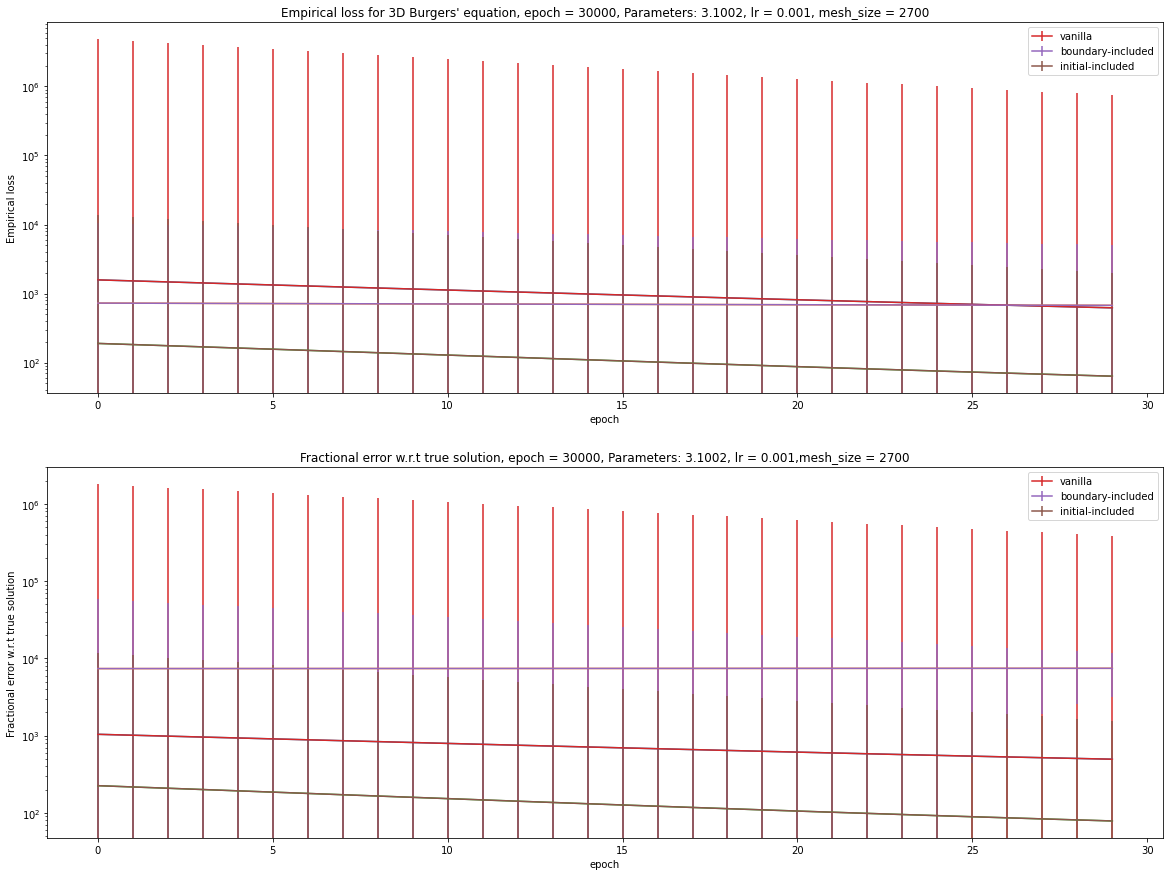

In [28]:
epoch = 30
import pickle
# layer_width_list = [4,40,200,300,1000,2000,3000]
nu_list = [0.01]
print(layer_width)

for i in range(len(nu_list)):
  nu = nu_list[i]
  print("current nu_list: {}".format(nu))
  loss_record_all = [[],[],[]]
  error_record_all = [[],[],[]]
  for i in range(3):
    print("current run: {}".format(i))
    net = Net(input_width,layer_width, layer_depth).to(device)
    initialize_weights(net)
    optimizer = optim.Adam(net.parameters())
    # %%
    loss_record = np.zeros(epoch)
    error_record = np.zeros(epoch)
    data_size = 2700
    x1 = generate_sample_one(data_size//3)
    x2 = generate_sample_two(data_size//3)
    x3 = generate_sample_three(data_size//3)
    time_start = time.time()
    for i in range(epoch):
        # scale_y[i] = float(model(scale_x))
        optimizer.zero_grad()
        loss = loss_function(x1, x2, x3, initial = False, boundary=False)
        loss_record[i] = float(loss)
        loss.backward()
        optimizer.step() 
        error_record[i] = cal_error(test_data_4, initial=False, boundary=False)
        torch.cuda.empty_cache() # clear memory
        print("Now epoch number is:{}".format(i),end='\r')
        if i % 2500 == 0:
          # y2.append(model(x2))
          print("current epoch is: ", i)
          print("current loss is: ", loss.detach())
    time_end = time.time()
    print('total time is: ', time_end-time_start, 'seconds')
    # plot_heatmap("venilla",initial=False, boundary=False)
    loss_record_all[0].append(loss_record)
    error_record_all[0].append(error_record)

    net = Net(input_width,layer_width, layer_depth).to(device)
    initialize_weights(net)
    optimizer = optim.Adam(net.parameters())
    # %%
    loss_record = np.zeros(epoch)
    error_record = np.zeros(epoch)
    time_start = time.time()
    for i in range(epoch):
        # scale_y[i] = float(model(scale_x))
        optimizer.zero_grad()
        loss = loss_function(x1, x2, x3, initial = False, boundary=True)
        loss_record[i] = float(loss)
        loss.backward()
        optimizer.step() 
        error_record[i] = cal_error(test_data_4, initial=False, boundary=True)
        torch.cuda.empty_cache() # clear memory
        print("Now epoch number is:{}".format(i),end='\r')
        if i % 2500 == 0:
          # y2.append(model(x2))
          print("current epoch is: ", i)
          print("current loss is: ", loss.detach())

    time_end = time.time()
    print('total time is: ', time_end-time_start, 'seconds')
    loss_record_all[1].append(loss_record)
    error_record_all[1].append(error_record)
    # plot_heatmap("boundary-included",initial=False, boundary=True)


    net = Net(input_width,layer_width, layer_depth).to(device)
    initialize_weights(net)
    optimizer = optim.Adam(net.parameters())
    # %%
    loss_record = np.zeros(epoch)
    error_record = np.zeros(epoch)
    time_start = time.time()
    for i in range(epoch):
        # scale_y[i] = float(model(scale_x))
        optimizer.zero_grad()
        loss = loss_function(x1, x2, x3, initial = True, boundary=False)
        loss_record[i] = float(loss)
        loss.backward()
        optimizer.step() 
        error_record[i] = cal_error(test_data_4, initial=True, boundary=False)
        torch.cuda.empty_cache() # clear memory
        print("Now epoch number is:{}".format(i),end='\r')
        if i % 2500 == 0:
          # y2.append(model(x2))
          print("current epoch is: ", i)
          print("current loss is: ", loss.detach())
    time_end = time.time()
    print('total time is: ', time_end-time_start, 'seconds')
    # plot_heatmap("initial-included",initial=True, boundary=False)
    loss_record_all[2].append(loss_record)
    error_record_all[2].append(error_record)

  with open('1D_burger_loss_record_all_nu={}width=300.pkl'.format(nu), 'wb') as f:
      pickle.dump([loss_record_all,error_record_all], f)

  avg_loss_record = []
  avg_error_record = []
  var_error_record = []
  var_loss_record = []
  for i in range(len(loss_record_all)):
      avg_loss_record.append(np.mean(loss_record_all[i], axis=0))
      avg_error_record.append(np.mean(error_record_all[i], axis=0))
      var_error_record.append(np.var(error_record_all[i], axis=0))
      var_loss_record.append(np.var(loss_record_all[i], axis=0))

  plot_loss_epoch(avg_loss_record, avg_error_record, epoch,var_loss_record, var_error_record, nu)





In [ ]:
print(avg_loss_record)

In [ ]:

avg_loss_record = []
avg_error_record = []

var_error_record = []
var_loss_record = []
for i in range(len(loss_record_all)):
    avg_loss_record.append(np.mean(loss_record_all[i], axis=0))
    avg_error_record.append(np.mean(error_record_all[i], axis=0))
    var_error_record.append(np.var(error_record_all[i], axis=0))
    var_loss_record.append(np.var(loss_record_all[i], axis=0))